In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import yfinance as yf
import talib as ta

from talib import RSI
from talib import MACD
from talib import STOCH
from talib import EMA
from talib import BBANDS

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM
from keras.optimizers import Adam

In [14]:
SPY = yf.download('SPY', interval = '1d', prepost = False, repair = True)
SPYmin = yf.download('SPY', interval = '1m', prepost = False, repair = True)
SPYdy = yf.download('SPY', interval = '1d', prepost = False, repair = True)
SPYwk = yf.download('SPY', interval = '1wk', prepost = False, repair = True)
SPYmo = yf.download('SPY', interval = '1mo', prepost = False, repair = True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
def indicators(ticker):
    #Generates the indicators for the tickers
    data = ticker
    data['RSI'] = RSI(ticker.Close, 14)
    macd = MACD(ticker.Close, 12, 26, 9)
    data['macd'] = macd[0] * 100
    data['macdSignal'] = macd[1] * 100
    stoch = STOCH(ticker.High, ticker.Low, ticker.Close, fastk_period = 5, slowk_period = 3, slowd_period = 3)
    data['SlowK'] = stoch[0]
    data['SlowD'] = stoch[1]
    BB = BBANDS(ticker.Close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    data['BB'] = ((data.Close - BB[1]) * 100/(BB[2] - BB[1]))
    data['EMA'] = EMA(ticker.Close, timeperiod = 10)
    data['Direction'] = ((data.Close - data.Close.shift(1)) > 0).astype(int)
    data = data[['RSI', 'macd', 'macdSignal', 'SlowK', 'SlowD', 'BB', 'Direction']]
    return data

In [4]:
def computeDirection(symbol):
    ticker = indicators(symbol)
    ticker.Direction = ticker.Direction.shift(-1)
    today =  ticker.iloc[-1,].to_frame().transpose() #Get current indicators to predict for the next move
    ticker = ticker.dropna()
    
    model = Sequential([
        LSTM(50,  input_shape=(6, 1), activation='relu'),
        Dense(16, activation = 'relu'),
        Dense(8, activation = 'relu'),
        Dense(2, activation = 'softmax')
])
    
    model.compile(Adam(lr = 0.001), loss = 'mean_squared_error', metrics = ['accuracy'])
    
    #last 20% of the data will be used for testing
    testIndex = int(len(ticker)*0.8)
    train = ticker[:testIndex]
    test = ticker[testIndex:]
    test = pd.concat([test, today])#merging the current test dataframe with current (today) 
    
    #Using RSI, MACD and StochOsc for predicting the Direction
    #Only using the preivous day indicators to predict the nect move
    train_x = train[['RSI', 'macd', 'macdSignal', 'SlowK', 'SlowD', 'BB']]
    train_y = pd.get_dummies(train['Direction']) #one hot encode for neural networks categorical
    test_x = test[['RSI', 'macd', 'macdSignal', 'SlowK', 'SlowD', 'BB']]
    test_y = pd.get_dummies(test['Direction'])
    
    model.fit(train_x, train_y, epochs = 20, verbose = 1)
    
    pred_y = model.predict(test_x)
    pred_y = np.round(pred_y, decimals = 0)
    pred_y = pd.DataFrame(pred_y).idxmax(axis = 1)
    predtest_y = pd.DataFrame(test_y).idxmax(axis = 1)
    return pd.DataFrame({'pred': pred_y, 'true': predtest_y.reset_index(drop = True)})

In [177]:
day = computeDirection(SPYdy)

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_33321/1630530735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker.Direction = ticker.Direction.shift(-1)


Epoch 1/20
191/191 [==============================] - 1s 2ms/step - loss: 0.2520 - accuracy: 0.5210
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.5287
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2488 - accuracy: 0.5312
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.5299
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.5305
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.5297
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.5290
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2484 - accuracy: 0.5299
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2482 - accuracy: 0.5348
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.5346

In [178]:
week = computeDirection(SPYwk)

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_33321/1630530735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker.Direction = ticker.Direction.shift(-1)


Epoch 1/20
39/39 [==============================] - 1s 2ms/step - loss: 0.3061 - accuracy: 0.5322
Epoch 2/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2699 - accuracy: 0.5515
Epoch 3/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.5539
Epoch 4/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2492 - accuracy: 0.5700
Epoch 5/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2447 - accuracy: 0.5733
Epoch 6/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2431 - accuracy: 0.5717
Epoch 7/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2407 - accuracy: 0.5878
Epoch 8/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2388 - accuracy: 0.5910
Epoch 9/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2365 - accuracy: 0.5910
Epoch 10/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.5918
Epoch 11/20
39/39 [

In [179]:
month = computeDirection(SPYmo)

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_33321/1630530735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker.Direction = ticker.Direction.shift(-1)


Epoch 1/20
9/9 [==============================] - 1s 3ms/step - loss: 0.3818 - accuracy: 0.6098
Epoch 2/20
9/9 [==============================] - 0s 2ms/step - loss: 0.3830 - accuracy: 0.6061
Epoch 3/20
9/9 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.6174
Epoch 4/20
9/9 [==============================] - 0s 2ms/step - loss: 0.3573 - accuracy: 0.6212
Epoch 5/20
9/9 [==============================] - 0s 2ms/step - loss: 0.3616 - accuracy: 0.6136
Epoch 6/20
9/9 [==============================] - 0s 2ms/step - loss: 0.3461 - accuracy: 0.6364
Epoch 7/20
9/9 [==============================] - 0s 2ms/step - loss: 0.3282 - accuracy: 0.6553
Epoch 8/20
9/9 [==============================] - 0s 2ms/step - loss: 0.3247 - accuracy: 0.6591
Epoch 9/20
9/9 [==============================] - 0s 2ms/step - loss: 0.3183 - accuracy: 0.6629
Epoch 10/20
9/9 [==============================] - 0s 2ms/step - loss: 0.2963 - accuracy: 0.6742
Epoch 11/20
9/9 [======================

In [180]:
#With 16, 8 node Dense Layer
day['Accuracy'] = day['pred'] == day['true']
week['Accuracy'] = week['pred'] == week['true']
month['Accuracy'] = month['pred'] == month['true']


a = sum(day.Accuracy)/len(day.Accuracy)
b = sum(week.Accuracy)/len(week.Accuracy)
c = sum(month.Accuracy)/len(month.Accuracy)
print(f'Day: {a}, Week: {b}, Month: {c}')

Day: 0.5406290956749672, Week: 0.5641025641025641, Month: 0.5882352941176471


In [170]:
#With 16, 16 node Dense Layer
day['Accuracy'] = day['pred'] == day['true']
week['Accuracy'] = week['pred'] == week['true']
month['Accuracy'] = month['pred'] == month['true']


a = sum(day.Accuracy)/len(day.Accuracy)
b = sum(week.Accuracy)/len(week.Accuracy)
c = sum(month.Accuracy)/len(month.Accuracy)
print(f'Day: {a}, Week: {b}, Month: {c}')

Day: 0.5131061598951507, Week: 0.48717948717948717, Month: 0.6470588235294118


In [70]:
#With 16, 32 node Dense Layer
day['Accuracy'] = day['pred'] == day['true']
week['Accuracy'] = week['pred'] == week['true']
month['Accuracy'] = month['pred'] == month['true']


a = sum(day.Accuracy)/len(day.Accuracy)
b = sum(week.Accuracy)/len(week.Accuracy)
c = sum(month.Accuracy)/len(month.Accuracy)
print(f'Day: {a}, Week: {b}, Month: {c}')

Day: 0.5363934426229509, Week: 0.5144694533762058, Month: 0.6268656716417911


In [60]:
#With 16, 32, 16 node Dense Layer
day['Accuracy'] = day['pred'] == day['true']
week['Accuracy'] = week['pred'] == week['true']
month['Accuracy'] = month['pred'] == month['true']


a = sum(day.Accuracy)/len(day.Accuracy)
b = sum(week.Accuracy)/len(week.Accuracy)
c = sum(month.Accuracy)/len(month.Accuracy)
print(f'Day: {a}, Week: {b}, Month: {c}')

Day: 0.5363934426229509, Week: 0.5048231511254019, Month: 0.6417910447761194


In [181]:
#The last row is the prediction for the next day
day.tail()

,pred,true,Accuracy
1521,1,0.0,False
1522,1,0.0,False
1523,1,1.0,True
1524,1,0.0,False
1525,1,0.0,False


In [182]:
#The last row is the prediction for the next week
week.tail()

,pred,true,Accuracy
307,0,1.0,False
308,0,1.0,False
309,0,1.0,False
310,0,0.0,True
311,0,0.0,True


In [183]:
#The last row is the prediction for the next month
month.tail()

,pred,true,Accuracy
63,1,1.0,True
64,0,1.0,False
65,0,1.0,False
66,0,1.0,False
67,1,0.0,False


In [5]:
#Calculation of accuracy in a function
def computeModel(symbol):
    ticker = indicators(symbol)
    ticker.Direction = ticker.Direction.shift(-1)
    today =  ticker.iloc[-1,].to_frame().transpose() #Get current indicators to predict for the next move
    ticker = ticker.dropna()
    
    model = Sequential([
        LSTM(50,  input_shape=(6, 1), activation='relu'),
        Dense(16, activation = 'relu'),
        Dense(8, activation = 'relu'),
        Dense(2, activation = 'softmax')
])
    
    model.compile(Adam(lr = 0.001), loss = 'mean_squared_error', metrics = ['accuracy'])
    
    #last 20% of the data will be used for testing
    testIndex = int(len(ticker)*0.8)
    train = ticker[:testIndex]
    test = ticker[testIndex:]
    test = pd.concat([test, today])#merging the current test dataframe with current (today) 
    
    #Using RSI, MACD and StochOsc for predicting the Direction
    #Only using the preivous day indicators to predict the nect move
    train_x = train[['RSI', 'macd', 'macdSignal', 'SlowK', 'SlowD', 'BB']]
    train_y = pd.get_dummies(train['Direction']) #one hot encode for neural networks categorical
    test_x = test[['RSI', 'macd', 'macdSignal', 'SlowK', 'SlowD', 'BB']]
    test_y = pd.get_dummies(test['Direction'])
    
    model.fit(train_x, train_y, epochs = 20, verbose = 1)
    return model

def finalIndicatorTable(symbol):
    ticker = indicators(symbol)
    ticker.Direction = ticker.Direction.shift(-1)
    return ticker

def accuracyTester(ticker, model):
    testIndex = int(len(ticker)*0.8)
    train = ticker[:testIndex]
    test = ticker[testIndex:]
    
    train_x = train[['RSI', 'macd', 'macdSignal', 'SlowK', 'SlowD', 'BB']]
    train_y = pd.get_dummies(train['Direction']) #one hot encode for neural networks categorical
    test_x = test[['RSI', 'macd', 'macdSignal', 'SlowK', 'SlowD', 'BB']]
    test_y = pd.get_dummies(test['Direction'])
    
    pred_y = model.predict(test_x)
    pred_y = np.round(pred_y, decimals = 0)
    pred_y = pd.DataFrame(pred_y).idxmax(axis = 1)
    predtest_y = pd.DataFrame(test_y).idxmax(axis = 1)
    
    df = pd.DataFrame({'pred': pred_y, 'true': predtest_y.reset_index(drop = True)})
    
    df['Accuracy'] = df['pred'] == df['true']
    a = sum(df.Accuracy)/len(df.Accuracy)
    print(f'Accuracy is: {a}')
    
    return df

In [7]:
modelMin = computeModel(SPYmin)

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_76689/3298358840.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker.Direction = ticker.Direction.shift(-1)


Epoch 1/20
48/48 [==============================] - 1s 2ms/step - loss: 0.3047 - accuracy: 0.5023
Epoch 2/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2607 - accuracy: 0.4958
Epoch 3/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.5056
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.5193
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.5160
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2491 - accuracy: 0.5415
Epoch 7/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2482 - accuracy: 0.5441
Epoch 8/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2468 - accuracy: 0.5460
Epoch 9/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2456 - accuracy: 0.5558
Epoch 10/20
48/48 [==============================] - 0s 2ms/step - loss: 0.2479 - accuracy: 0.5376
Epoch 11/20
48/48 [

In [22]:
#Predicting the move for the next MINUTE
SPYmin = yf.download('SPY', interval = '1m', prepost = False, repair = True)
SPYmin = finalIndicatorTable(SPYmin)
accuracyTester(SPYmin, modelMin)
#The last row is the prediction -> one hot encode for NaN is [0, 0]

[*********************100%***********************]  1 of 1 completed
13/13 [==============================] - 0s 826us/step
Accuracy is: 0.5384615384615384


/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_76689/3298358840.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker.Direction = ticker.Direction.shift(-1)


,pred,true,Accuracy
0,1,0.0,False
1,1,1.0,True
2,1,1.0,True
3,1,1.0,True
4,1,1.0,True
...,...,...,...
385,1,0.0,False
386,0,1.0,False
387,0,0.0,True
388,0,1.0,False


In [15]:
modelDaily = computeModel(SPYdy)

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_89999/3298358840.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker.Direction = ticker.Direction.shift(-1)


Epoch 1/20
191/191 [==============================] - 1s 2ms/step - loss: 0.2836 - accuracy: 0.5066
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2550 - accuracy: 0.5246
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2523 - accuracy: 0.5252
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2501 - accuracy: 0.5218
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.5270
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.5259
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2492 - accuracy: 0.5310
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2491 - accuracy: 0.5272
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2488 - accuracy: 0.5292
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2489 - accuracy: 0.5302

In [16]:
#Predicting the move for the next DAY
SPYtoday = yf.download('SPY', start = '2022-01-01', interval = '1d', prepost = False, repair = True)
SPYtodayx = finalIndicatorTable(SPYtoday)
accuracyTester(SPYtodayx, modelDaily).tail(10)
#The last row is the prediction -> one hot encode for NaN is [0, 0]

[*********************100%***********************]  1 of 1 completed


/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_89999/3298358840.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker.Direction = ticker.Direction.shift(-1)


3/3 [==============================] - 0s 1ms/step
Accuracy is: 0.5866666666666667


,pred,true,Accuracy
65,1,0.0,False
66,1,0.0,False
67,1,1.0,True
68,1,0.0,False
69,1,0.0,False
70,1,1.0,True
71,1,1.0,True
72,1,1.0,True
73,1,1.0,True
74,1,0.0,False


In [17]:
modelWeek = computeModel(SPYwk)

/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_89999/3298358840.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker.Direction = ticker.Direction.shift(-1)


Epoch 1/20
39/39 [==============================] - 1s 2ms/step - loss: 0.3337 - accuracy: 0.5076
Epoch 2/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.5366
Epoch 3/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2623 - accuracy: 0.5455
Epoch 4/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2629 - accuracy: 0.5543
Epoch 5/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2510 - accuracy: 0.5664
Epoch 6/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2459 - accuracy: 0.5704
Epoch 7/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2432 - accuracy: 0.5768
Epoch 8/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2377 - accuracy: 0.5881
Epoch 9/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2394 - accuracy: 0.5897
Epoch 10/20
39/39 [==============================] - 0s 2ms/step - loss: 0.2386 - accuracy: 0.5873
Epoch 11/20
39/39 [

In [18]:
#Predicting the move for the next DAY
SPYweek = yf.download('SPY', start = '2020-01-01', interval = '1wk', prepost = False, repair = True)
SPYweekx = finalIndicatorTable(SPYweek)
accuracyTester(SPYweekx, modelWeek).tail(10)
#The last row is the prediction -> one hot encode for NaN is [0, 0]

[*********************100%***********************]  1 of 1 completed


/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_89999/3298358840.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker.Direction = ticker.Direction.shift(-1)


2/2 [==============================] - 0s 2ms/step
Accuracy is: 0.5675675675675675


,pred,true,Accuracy
27,1,1.0,True
28,0,0.0,True
29,1,1.0,True
30,0,1.0,False
31,1,1.0,True
32,1,1.0,True
33,1,1.0,True
34,0,0.0,True
35,0,1.0,False
36,0,0.0,True


In [ ]:
#Run on the monthly to find the month to sell
#Followed by running on the weekly to find the week to sell
#Then the daily to find the day to sell

#If (start of chain) 1 -> Buy
#If (start of chain) 0 -> Sell

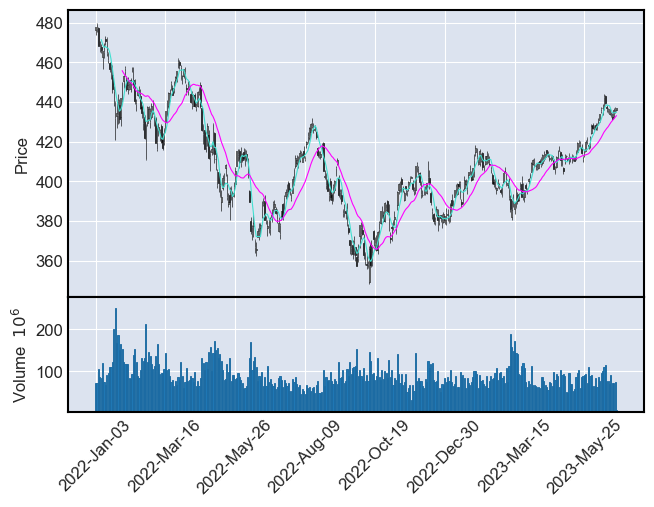

In [8]:
mpf.plot(SPYtoday, type = 'candle', mav = (5, 20), volume = True)